In [5]:
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
from evalscripts import evalscript_baresoil, evalscript_ndvi
from matplotlib import pyplot as plt

from eolearn.core import EOPatch, FeatureType
from eolearn.features import NormalizedDifferenceIndexTask
from eolearn.io import SentinelHubEvalscriptTask, SentinelHubInputTask
from eolearn.mask.extra.cloud_mask import CloudMaskTask
from sentinelhub import CRS, BBox, Geometry, SentinelHubCatalog, SHConfig
from sentinelhub.api.statistical import SentinelHubStatistical
from sentinelhub.data_collections import DataCollection
from sentinelhub.data_utils import statistical_to_dataframe
from sentinelhub.download.sentinelhub_statistical_client import SentinelHubStatisticalDownloadClient

## Overview

This notebook demonstrates how to retrieve, process, and analyze satellite imagery for agricultural monitoring using the Climate Change Monitoring & CAP Compliance Toolbox. The workflow includes retrieving Sentinel-2 satellite imagery over a defined area of interest, applying cloud masking to filter out cloudy observations, calculating vegetation indices like NDVI (Normalized Difference Vegetation Index), and detecting bare soil. 

The notebook showcases time-series analysis of these vegetation indices, visualizing how they change over time from March to September 2024. Multiple visualizations are created to correlate the satellite imagery with the calculated NDVI values, allowing users to track vegetation growth patterns and identify potential agricultural activities like harvesting or planting. This analysis is particularly useful for crop monitoring, compliance verification, and environmental assessment applications. 


The notebook utilizes the **eo-learn** library, an open-source Python framework for Earth observation (EO) data processing, and **sentinelhub-py**, a Python library for downloading and processing satellite imagery from Sentinel Hub services. These libraries provide a set of tools for creating reproducible and scalable workflows for working with satellite imagery. The libraries are being continuously developed to address the needs that arise within AgriDataValue. Key features demonstrated include:

- **Sentinel Hub Integration**: Connecting to the Copernicus Data Space Ecosystem deployment of Sentinel Hub to retrieve Sentinel-2 satellite imagery using `sentinelhub-py`.
- **EOPatch Structure**: Managing data within specialized container objects that handle both spatial and temporal dimensions using `eo-learn`.
- **Cloud Masking**: Filtering out cloudy observations to ensure high-quality time series analysis.
- **Vegetation Indices**: Calculating NDVI (Normalized Difference Vegetation Index) to track vegetation health.
- **Bare Soil Detection**: Implementing specialized algorithms to identify exposed soil within agricultural fields.
- **Time Series Analysis**: Creating temporal profiles of vegetation indices to monitor crop development cycles.

This approach enables efficient monitoring of agricultural parcels, supporting applications in crop management, yield prediction, and compliance verification.
This notebook is supposed to showcase a basic workflow that can be used for agricultural monitoring. In practice, we could use different vegetation indices, use this data for modelling etc. 

In [ ]:
config = SHConfig(profile="adv-demonstrator")
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
catalog = SentinelHubCatalog(config=config)

# Get data 

In [32]:
aoi = (
    "MultiPolygon (((5.62727999999999806 52.57638200000000239, 5.62831499999999885 52.57421099999998404,"
    " 5.6264909999999988 52.5739369999999937, 5.62683499999999892 52.57318000000000069, 5.62548299999999823"
    " 52.57295899999998312, 5.62494599999999956 52.57430300000000756, 5.62429199999999785 52.57587999999999084,"
    " 5.62727999999999806 52.57638200000000239)))"
)

In [33]:
aoi = shapely.wkt.loads(aoi)

## Data Retrieval and Processing Workflow

This section describes the process of retrieving and processing Sentinel-2 satellite imagery for our agricultural monitoring application. The workflow consists of the following steps:

1. **Create an EOPatch**: We initialize an Earth Observation Patch (EOPatch) based on our area of interest (AOI). The EOPatch acts as a container for all satellite data and derived products.

2. **Configure Data Collection**: We set up the Sentinel-2 L1C data collection to connect to the Copernicus Data Space Ecosystem deployment of Sentinel HUb. 

3. **Define Processing Tasks**: We establish a processing pipeline including:
    - Cloud masking to filter out cloudy observations
    - NDVI calculation to assess vegetation health
    - Bare soil detection to identify exposed agricultural soils

4. **Execute Processing Chain**: The execution will download Sentinel-2 imagery over our area of interest for the specified time period (March to September 2024), and apply all defined processing steps.

5. **Filter Results**: We identify cloud-free observations to ensure high-quality analysis.

6. **Statistical Analysis**: We extract time series statistics of vegetation indices to monitor crop development patterns.

In [34]:
eop = EOPatch(bbox=BBox(aoi.bounds, crs=CRS.WGS84))

In [35]:
s2l1c_collection = DataCollection.SENTINEL2_L1C
s2l1c_collection.service_url = config.sh_base_url

In [36]:
cloud_masking = CloudMaskTask(
    data_feature=(FeatureType.DATA, "BANDS"),
    valid_data_feature=(FeatureType.MASK, "dataMask"),
    output_mask_feature=(FeatureType.MASK, "CLM"),
    output_proba_feature=(FeatureType.DATA, "CLP"),
    all_bands=True,
)

In [37]:
def collection_statistics(pilot_geom, collection, interval_start, interval_end, evalscript):
    collection_requests = []

    lon, lat = pilot_geom.centroid.x, pilot_geom.centroid.y
    utm_crs = CRS.get_utm_from_wgs84(lon, lat)

    transform_function = CRS.WGS84.get_transform_function(utm_crs, always_xy=True)
    geometry = shapely.ops.transform(transform_function, pilot_geom)
    if geometry.area == 0:
        geometry = geometry.buffer(20)

    geom_utm = Geometry(geometry, utm_crs)

    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(
            evalscript=evalscript,
            time_interval=(interval_start, interval_end),  # TODO
            aggregation_interval="P1D",
            resolution=(10, 10),
        ),
        input_data=[SentinelHubStatistical.input_data(collection)],
        geometry=geom_utm,
        config=config,
        data_folder="./datax",
    )
    collection_requests.append(request)

    download_requests = [coll_request.download_list[0] for coll_request in collection_requests]
    client = SentinelHubStatisticalDownloadClient(config=config)
    collection_stats = client.download(download_requests)
    stats = statistical_to_dataframe(collection_stats)
    band_mean_cols = [x for x in stats.columns if x.startswith("bands_") and x.endswith("mean")]
    stats = stats[band_mean_cols + ["interval_from", "interval_to"]]
    return stats

In [38]:
input_task = SentinelHubInputTask(
    data_collection=s2l1c_collection,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    bands_feature=(FeatureType.DATA, "BANDS"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=10,
    maxcc=0.5,
    time_difference=datetime.timedelta(hours=2),
    config=config,
    max_threads=3,
)

cloud_masking = CloudMaskTask(
    data_feature=(FeatureType.DATA, "BANDS"),
    valid_data_feature=(FeatureType.MASK, "dataMask"),
    output_mask_feature=(FeatureType.MASK, "CLM"),
    output_proba_feature=(FeatureType.DATA, "CLP"),
    all_bands=True,
)

compute_ndvi = NormalizedDifferenceIndexTask(
    input_feature=(FeatureType.DATA, "BANDS"), output_feature=(FeatureType.DATA, "NDVI"), bands=(8, 4)
)

baresoil_marker = SentinelHubEvalscriptTask(
    features=[(FeatureType.DATA, "baresoil")],
    evalscript=evalscript_baresoil,
    data_collection=s2l1c_collection,
    resolution=10,
    maxcc=0.5,
    time_difference=datetime.timedelta(hours=2),
    config=config,
    max_threads=3,
)

In [39]:
eop = input_task.execute(eop, time_interval=(datetime.datetime(2024, 3, 1), datetime.datetime(2024, 10, 1)))
eop = cloud_masking.execute(eop)
eop = compute_ndvi.execute(eop)
eop = baresoil_marker.execute(eop)

In [40]:
cloud_free_indices = np.argwhere((eop.mask["CLM"].mean(axis=(1, 2)) < 0.2).squeeze())

In [41]:
stats = collection_statistics(
    aoi, s2l1c_collection, datetime.datetime(2024, 3, 1), datetime.datetime(2024, 10, 1), evalscript_ndvi
)

In [42]:
stats_days = stats.interval_from.dt.to_pydatetime()

/tmp/ipykernel_6228/1169163150.py:1: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  stats_days = stats.interval_from.dt.to_pydatetime()


In [43]:
common_dates = set([x.date() for x in stats_days]).intersection(
    set([x.item().date() for x in np.array(eop.timestamps)[cloud_free_indices]])
)

In [44]:
cloud_free_stats = stats[stats.interval_from.apply(lambda x: x.date() in (common_dates))]

The visualization in the plot above demonstrates the temporal evolution of our agricultural parcel from March to September 2024, showing the complete growing season. 

On the top row we see the **True Color Images** - RGB renderings of the Sentinel-2 imagery showing how the parcel appears visually over time. The red outline indicates our area of interest.
In the middle we show the **NDVI Visualization** - NDVI (Normalized Difference Vegetation Index) maps of the same area, where greener colors indicate higher vegetation vigor/density.
In the bottom row, we show the **Time Series Plot** - Quantitative representation of mean NDVI values across the parcel for each cloud-free observation date. The red dashed vertical lines indicate detection of bare soil conditions.

The visualization effectively captures the agricultural cycle:
- Early spring (March-April): Low NDVI values indicating minimal vegetation or bare soil after winter
- Late spring/early summer (May-June): Increasing NDVI values showing crop development and growth
- Mid-summer (July): Peak NDVI values representing maximum crop vigor/canopy development
- Late summer/early fall (August-September): Declining NDVI values suggesting crop maturation and potential harvesting activity

This time series analysis enables us to identify key agricultural events such as planting, peak growth, and harvesting periods. The correlation between NDVI trends and baresoil detection provides insights into land management practices on this parcel, supporting the monitoring capabilities described in the project overview.

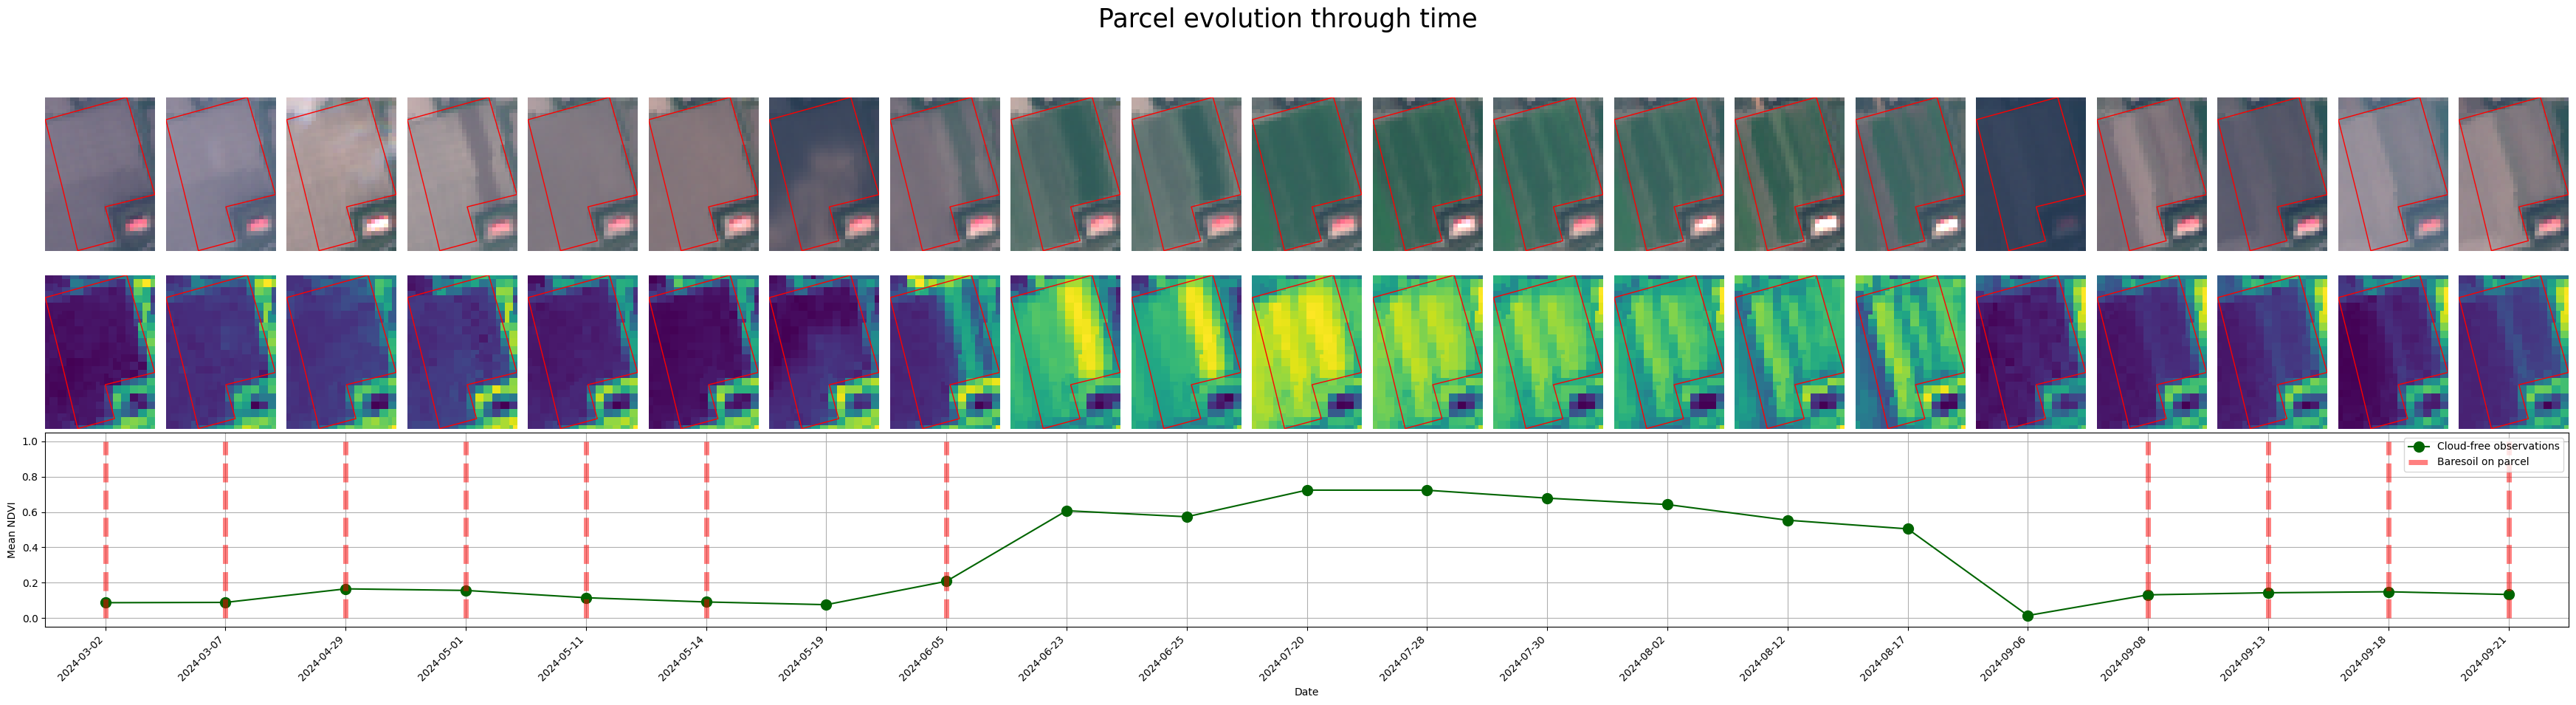

In [75]:
fig = plt.figure(figsize=(35, 10))
fig.suptitle("Parcel evolution through time", fontsize=25)

ncols = len(cloud_free_stats)

gs = fig.add_gridspec(3, ncols)
axs_images = [[None for _ in range(ncols)] for _ in range(2)]

for i in range(ncols):
    axs_images[0][i] = fig.add_subplot(gs[0, i])
    axs_images[1][i] = fig.add_subplot(gs[1, i], sharex=axs_images[0][i])

ax_stats = fig.add_subplot(gs[2, :])


n = len(cloud_free_indices)

cloud_free_bands = eop.data["BANDS"][cloud_free_indices]
cloud_free_ndvi = eop.data["NDVI"][cloud_free_indices]
cloud_free_baresoil = eop.data["baresoil"][cloud_free_indices]

extent = np.array(eop.bbox.geometry.bounds)[[0, 2, 1, 3]]

image_timestamps = [ts for ts in np.array(eop.timestamps)[cloud_free_indices]]


for i, (ts, image_rgb, image_ndvi, baresoil) in enumerate(
    zip(np.array(eop.timestamps)[cloud_free_indices], cloud_free_bands, cloud_free_ndvi, cloud_free_baresoil)
):
    axs_images[0][i].imshow(np.clip(image_rgb[..., [3, 2, 1]].squeeze() * 3.5, 0, 1), extent=extent)
    axs_images[1][i].imshow(image_ndvi.squeeze(), extent=extent)
    gpd.GeoDataFrame(geometry=[aoi], crs=4326).plot(ax=axs_images[0][i], color="none", edgecolor="red")
    gpd.GeoDataFrame(geometry=[aoi], crs=4326).plot(ax=axs_images[1][i], color="none", edgecolor="red")
    axs_images[0][i].axis("off")
    axs_images[1][i].axis("off")


ax_stats.plot(
    cloud_free_stats.reset_index().index,
    cloud_free_stats.bands_NDVI_mean,
    "o",
    color="darkgreen",
    ls="-",
    markersize=10,
    label="Cloud-free observations",
)

ax_stats.vlines(
    np.argwhere((cloud_free_baresoil.mean(axis=(2, 3)).squeeze() / 255) > 0.5),
    ymin=0,
    ymax=1,
    color="red",
    label="Baresoil on parcel",
    linestyles="dashed",
    alpha=0.5,
    lw=5,
)
ax_stats.set_xlim(-0.5, len(cloud_free_stats) - 0.5)

ax_stats.set_xlabel("Date")
ax_stats.set_ylabel("Mean NDVI")
ax_stats.legend()
ax_stats.grid(True)
ax_stats.set_xticks(np.arange(len(cloud_free_stats)))
ax_stats.set_xticklabels(cloud_free_stats.interval_from.dt.strftime("%Y-%m-%d"), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()